In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import re

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split

import xgboost as xgb

from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential

from collections import Counter

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
data = pd.read_csv("SolarPrediction.csv")

In [5]:
data.head(10)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00
5,1475227824,9/29/2016 12:00:00 AM,23:30:24,1.21,48,30.46,64,120.20,5.62,06:13:00,18:13:00
6,1475227519,9/29/2016 12:00:00 AM,23:25:19,1.20,49,30.46,72,112.45,6.75,06:13:00,18:13:00
7,1475227222,9/29/2016 12:00:00 AM,23:20:22,1.24,49,30.46,71,122.97,5.62,06:13:00,18:13:00
8,1475226922,9/29/2016 12:00:00 AM,23:15:22,1.23,49,30.46,80,101.18,4.50,06:13:00,18:13:00
9,1475226622,9/29/2016 12:00:00 AM,23:10:22,1.21,49,30.46,85,141.87,4.50,06:13:00,18:13:00


# Data Wrangling

In [6]:
df = data.copy()

In [7]:
# extract the date from the date_time format of the 'Data' parameter
df["Data"] = df["Data"].apply(lambda x : x.split(" ")[0])

In [8]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [9]:
# extract the date time features from the given parameter using date time python methods
df["Month"] = pd.to_datetime(df["Data"]).dt.month
df["Day"] = pd.to_datetime(df["Data"]).dt.day
df["Hour"] = pd.to_datetime(df["Time"]).dt.hour
df["Minute"] = pd.to_datetime(df["Time"]).dt.minute
df["Second"] = pd.to_datetime(df["Time"]).dt.second

In [10]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24


In [11]:
df["RiseHour"] = df["TimeSunRise"].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(int)

In [12]:
df["RiseMinute"] = df["TimeSunRise"].apply(lambda x: re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

In [13]:
df["SetHour"] = df["TimeSunSet"].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(int)

In [14]:
df["SetMinute"] = df["TimeSunSet"].apply(lambda x: re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

In [15]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second,RiseHour,RiseMinute,SetHour,SetMinute
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26,6,13,18,13
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23,6,13,18,13
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26,6,13,18,13
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21,6,13,18,13
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24,6,13,18,13


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
 11  Month                   32686 non-null  int64  
 12  Day                     32686 non-null  int64  
 13  Hour                    32686 non-null  int64  
 14  Minute                  32686 non-null

In [17]:
df.drop(["Data", "Time", "TimeSunRise", "TimeSunSet"], axis=1, inplace=True)

In [18]:
df.head()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,RiseHour,RiseMinute,SetHour,SetMinute
0,1475229326,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,1475229023,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,1475228726,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,1475228421,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,1475228124,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


# Selecting Input and Target Parameters

In [19]:
x = df.drop(["Radiation"], axis=1)
y = df["Radiation"]

In [20]:
x.shape

(32686, 15)

In [21]:
x.isnull().sum()

UNIXTime                  0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
Month                     0
Day                       0
Hour                      0
Minute                    0
Second                    0
RiseHour                  0
RiseMinute                0
SetHour                   0
SetMinute                 0
dtype: int64

In [22]:
y.shape

(32686,)

In [23]:
y.isnull().sum()

0

# Feature Selection using Correlation Matrix
$$
r=\frac{\sum\left(x_i-\bar{x}\right)\left(y_i-\bar{y}\right)}{\sqrt{\sum\left(x_i-\bar{x}\right)^2 \sum\left(y_i-\bar{y}\right)^2}}
$$
- $r=$ correlation coefficient
- $x_i=$ values of the $\mathrm{x}$-variable in a sample
- $\bar{x}=$ mean of the values of the $\mathrm{x}$-variable
- $y_i=$ values of the $y$-variable in a sample
- $\bar{y}=$ mean of the values of the $y$-variable together.


In [24]:
corr_mat = df.corr()
corr_mat

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,RiseHour,RiseMinute,SetHour,SetMinute
UNIXTime,1.000000,-0.081286,-0.369169,-0.332016,-0.063117,0.152613,0.173860,0.968235,0.286457,0.001056,0.000406,0.231002,NaN,0.981908,-0.818884,0.586612
Radiation,-0.081286,1.000000,0.734955,0.119016,-0.226171,-0.230324,0.073627,-0.095450,0.039978,0.004398,-0.000730,-0.031270,NaN,-0.092850,0.048719,-0.039816
Temperature,-0.369169,0.734955,1.000000,0.311173,-0.285055,-0.259421,-0.031458,-0.354560,-0.123705,0.197464,-0.001934,-0.036147,NaN,-0.380968,0.300920,-0.242881
Pressure,-0.332016,0.119016,0.311173,1.000000,-0.223973,-0.229010,-0.083639,-0.341759,-0.024633,0.091069,0.001860,-0.031102,NaN,-0.380399,0.151939,-0.119599
Humidity,-0.063117,-0.226171,-0.285055,-0.223973,1.000000,-0.001833,-0.211624,-0.068854,0.014637,0.077899,0.000499,-0.027682,NaN,-0.023955,0.145143,-0.119526
WindDirection(Degrees),0.152613,-0.230324,-0.259421,-0.229010,-0.001833,1.000000,0.073092,0.181485,-0.082354,-0.077969,-0.000602,-0.032568,NaN,0.176929,-0.078540,0.070030
Speed,0.173860,0.073627,-0.031458,-0.083639,-0.211624,0.073092,1.000000,0.150822,0.117337,-0.057939,0.000192,-0.032934,NaN,0.167075,-0.159384,0.119926
Month,0.968235,-0.095450,-0.354560,-0.341759,-0.068854,0.181485,0.150822,1.000000,0.038027,-0.005396,0.000168,0.220563,NaN,0.952472,-0.784783,0.541883
Day,0.286457,0.039978,-0.123705,-0.024633,0.014637,-0.082354,0.117337,0.038027,1.000000,-0.008010,-0.000196,0.089078,NaN,0.274522,-0.263575,0.265662
Hour,0.001056,0.004398,0.197464,0.091069,0.077899,-0.077969,-0.057939,-0.005396,-0.008010,1.000000,-0.004052,0.004199,NaN,-0.006772,0.008629,-0.007056


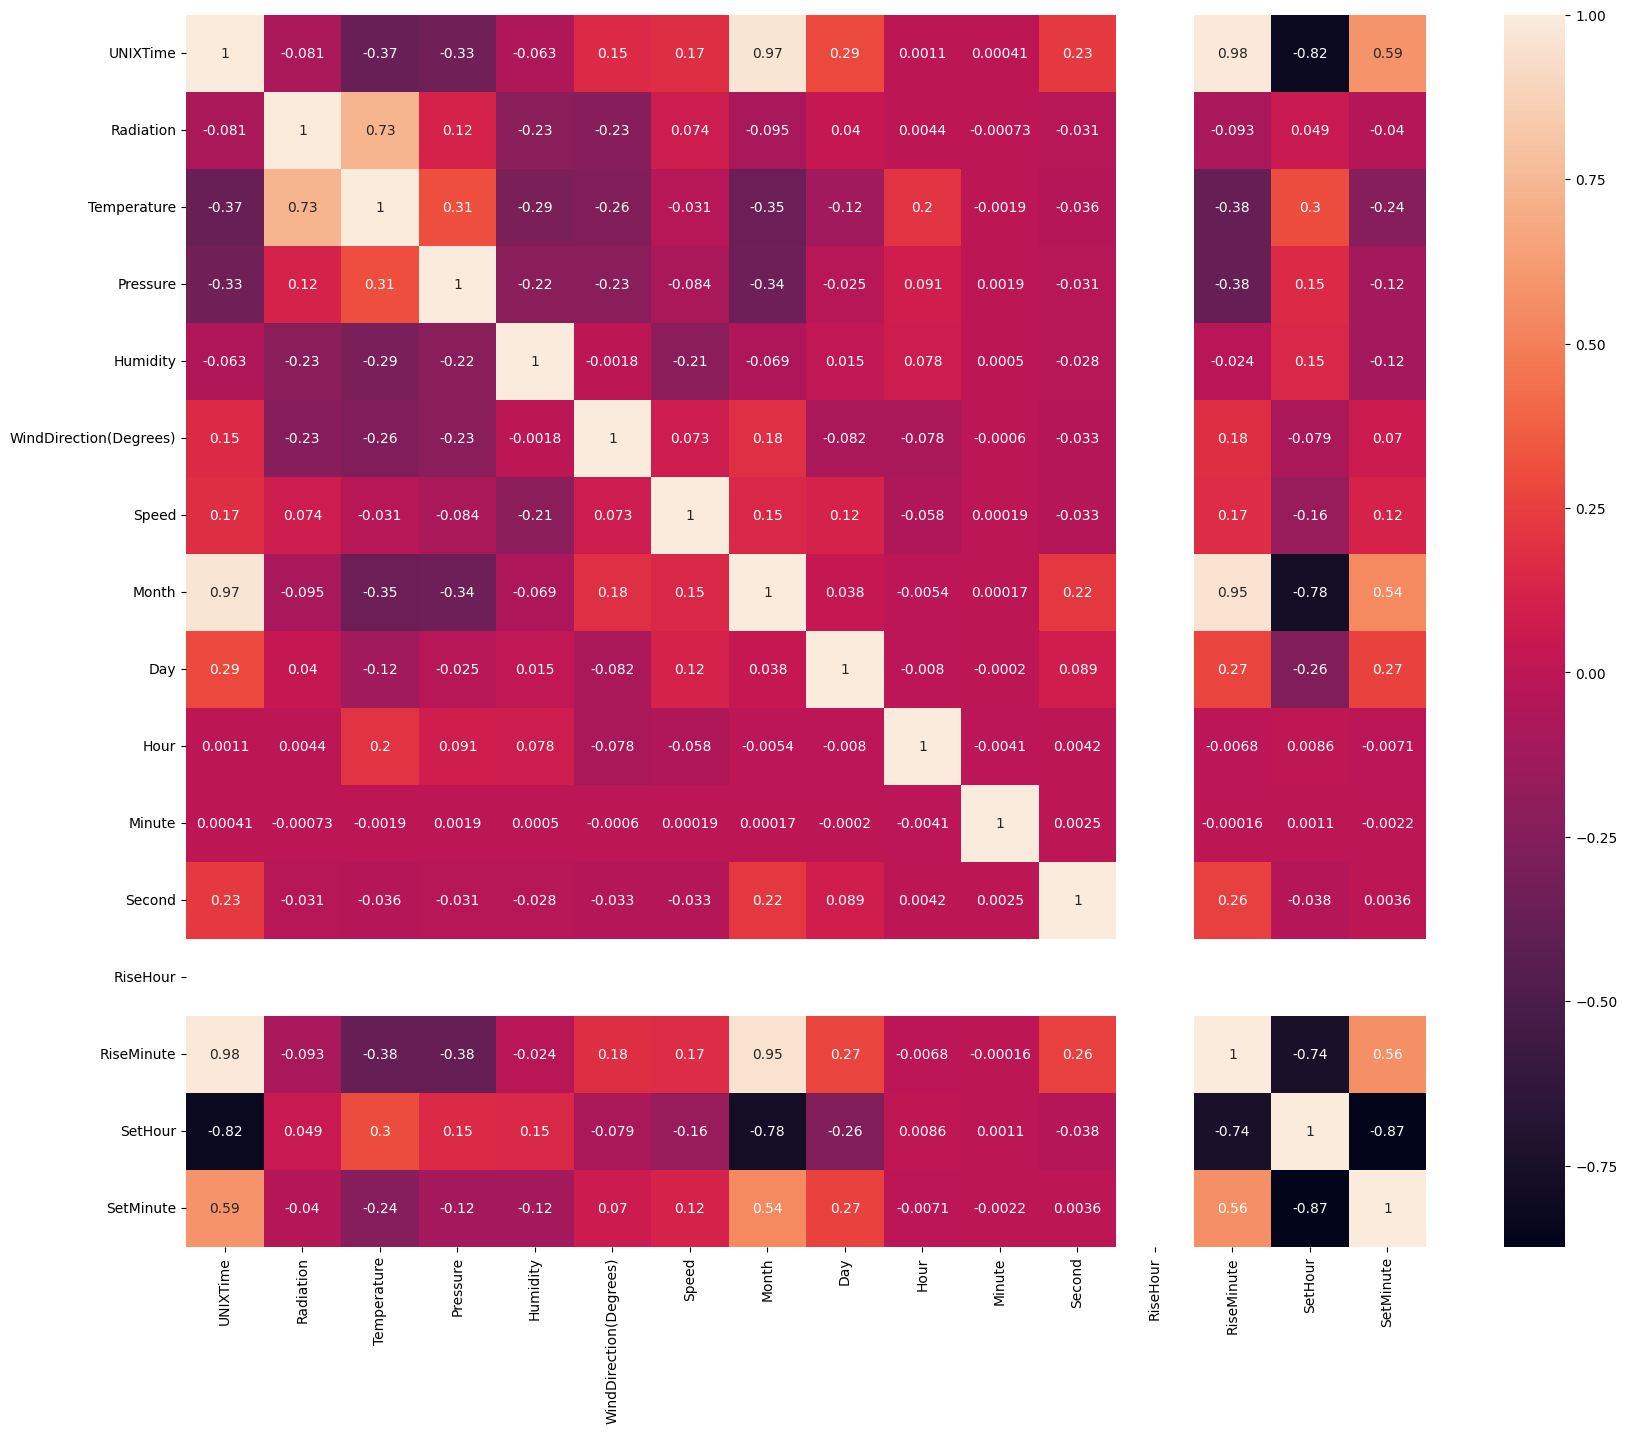

In [25]:
plt.figure(figsize=[20,16])
sns.heatmap(corr_mat, annot=True)
plt.show()

# Feature Selection using SelectKBest Method

In [26]:
bestfeatures = SelectKBest(score_func = chi2, k=10)

In [27]:
#use label encoder
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
y_rev = label_enc.fit_transform(y)

In [28]:
y_rev

array([ 9,  9, 11, ...,  8, 11,  8], dtype=int64)

In [29]:
target_cont = df["Radiation"].apply(lambda x : int(x*100))

In [30]:
target_cont

0        121
1        121
2        123
3        121
4        117
        ... 
32681    122
32682    117
32683    120
32684    123
32685    120
Name: Radiation, Length: 32686, dtype: int64

In [32]:
scaled_x = MinMaxScaler().fit_transform(x)
fit = bestfeatures.fit(scaled_x, target_cont)

In [34]:
scores = pd.DataFrame(fit.scores_)
features = pd.DataFrame(x.columns)

In [38]:
features_df = pd.concat([scores, features], axis=1)

In [40]:
features_df.columns = ["Score", "Feature"]

In [43]:
features_df.sort_values(by="Score", ascending = False, inplace=True)

In [44]:
features_df

,Score,Feature
13,12207.531454,SetHour
6,4684.579610,Month
12,4015.062771,RiseMinute
4,3271.827277,WindDirection(Degrees)
0,3026.266167,UNIXTime
7,2841.926850,Day
9,2702.449333,Minute
10,2288.673032,Second
14,1863.712087,SetMinute
1,1651.685632,Temperature


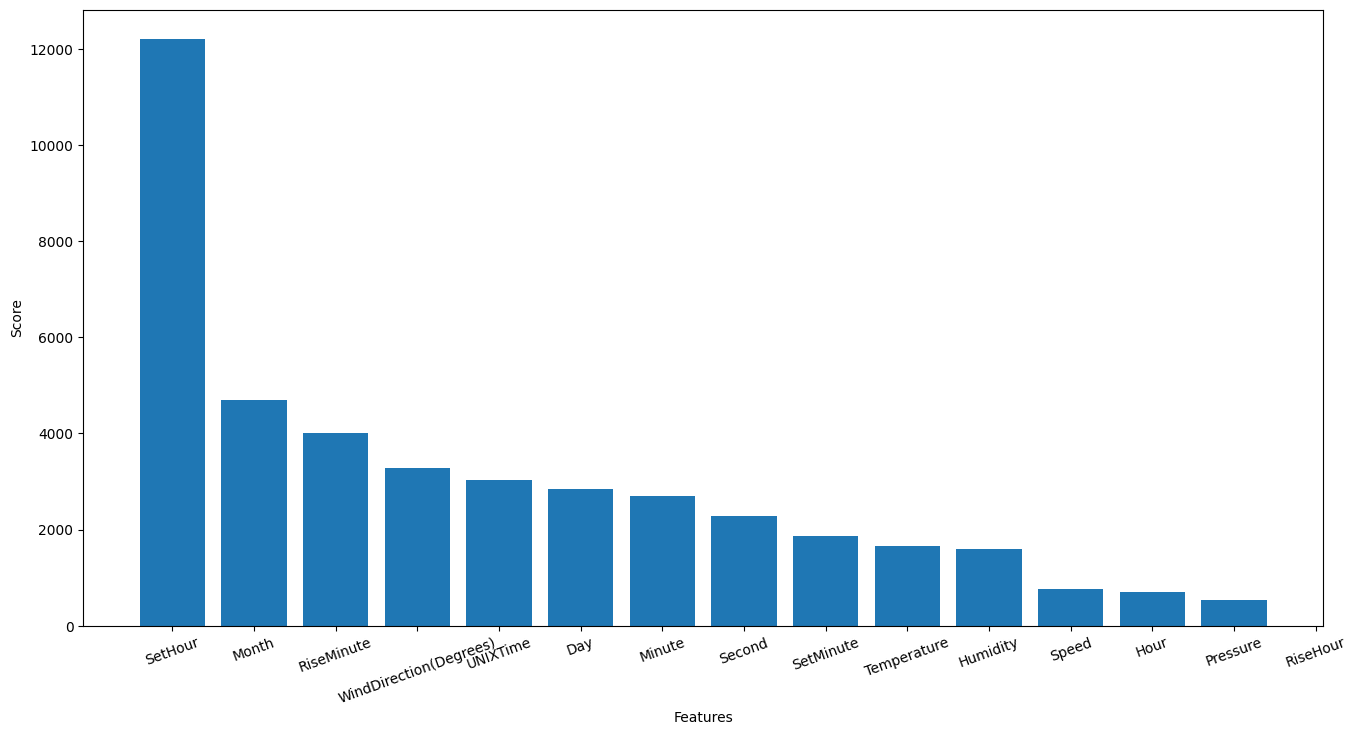

In [49]:
plt.figure(figsize=[16,8])
plt.bar(features_df["Feature"], features_df["Score"])
plt.xlabel("Features")
plt.ylabel("Score")
plt.xticks(rotation=20)
plt.show()

# Feature Selection using ExtraTreeClassifier

In [52]:
model = ExtraTreesClassifier(verbose=2, n_estimators=10)
model.fit(scaled_x, target_cont)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.0s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10


MemoryError: could not allocate 7498891264 bytes

In [ ]:
features_imp_df = pd.DataFrame(model.feature_importances_, index=x.columns, columns=["Importance"])
features